In [84]:
import sys
import cv2
import matplotlib.pyplot as plt
from testSilhouettes import *
import numpy as np
from skimage.filters import gabor_kernel
%matplotlib inline

In [85]:
image = cv2.imread("/Users/yingyu/INF574/images/m1004_outfile_1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

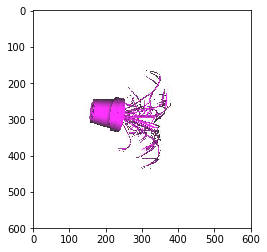

In [86]:
plt.imshow(image)
plt.show()
image = cv2.resize(image, (600, 600), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

In [87]:
 edges = cv2.Canny(image,199,199)

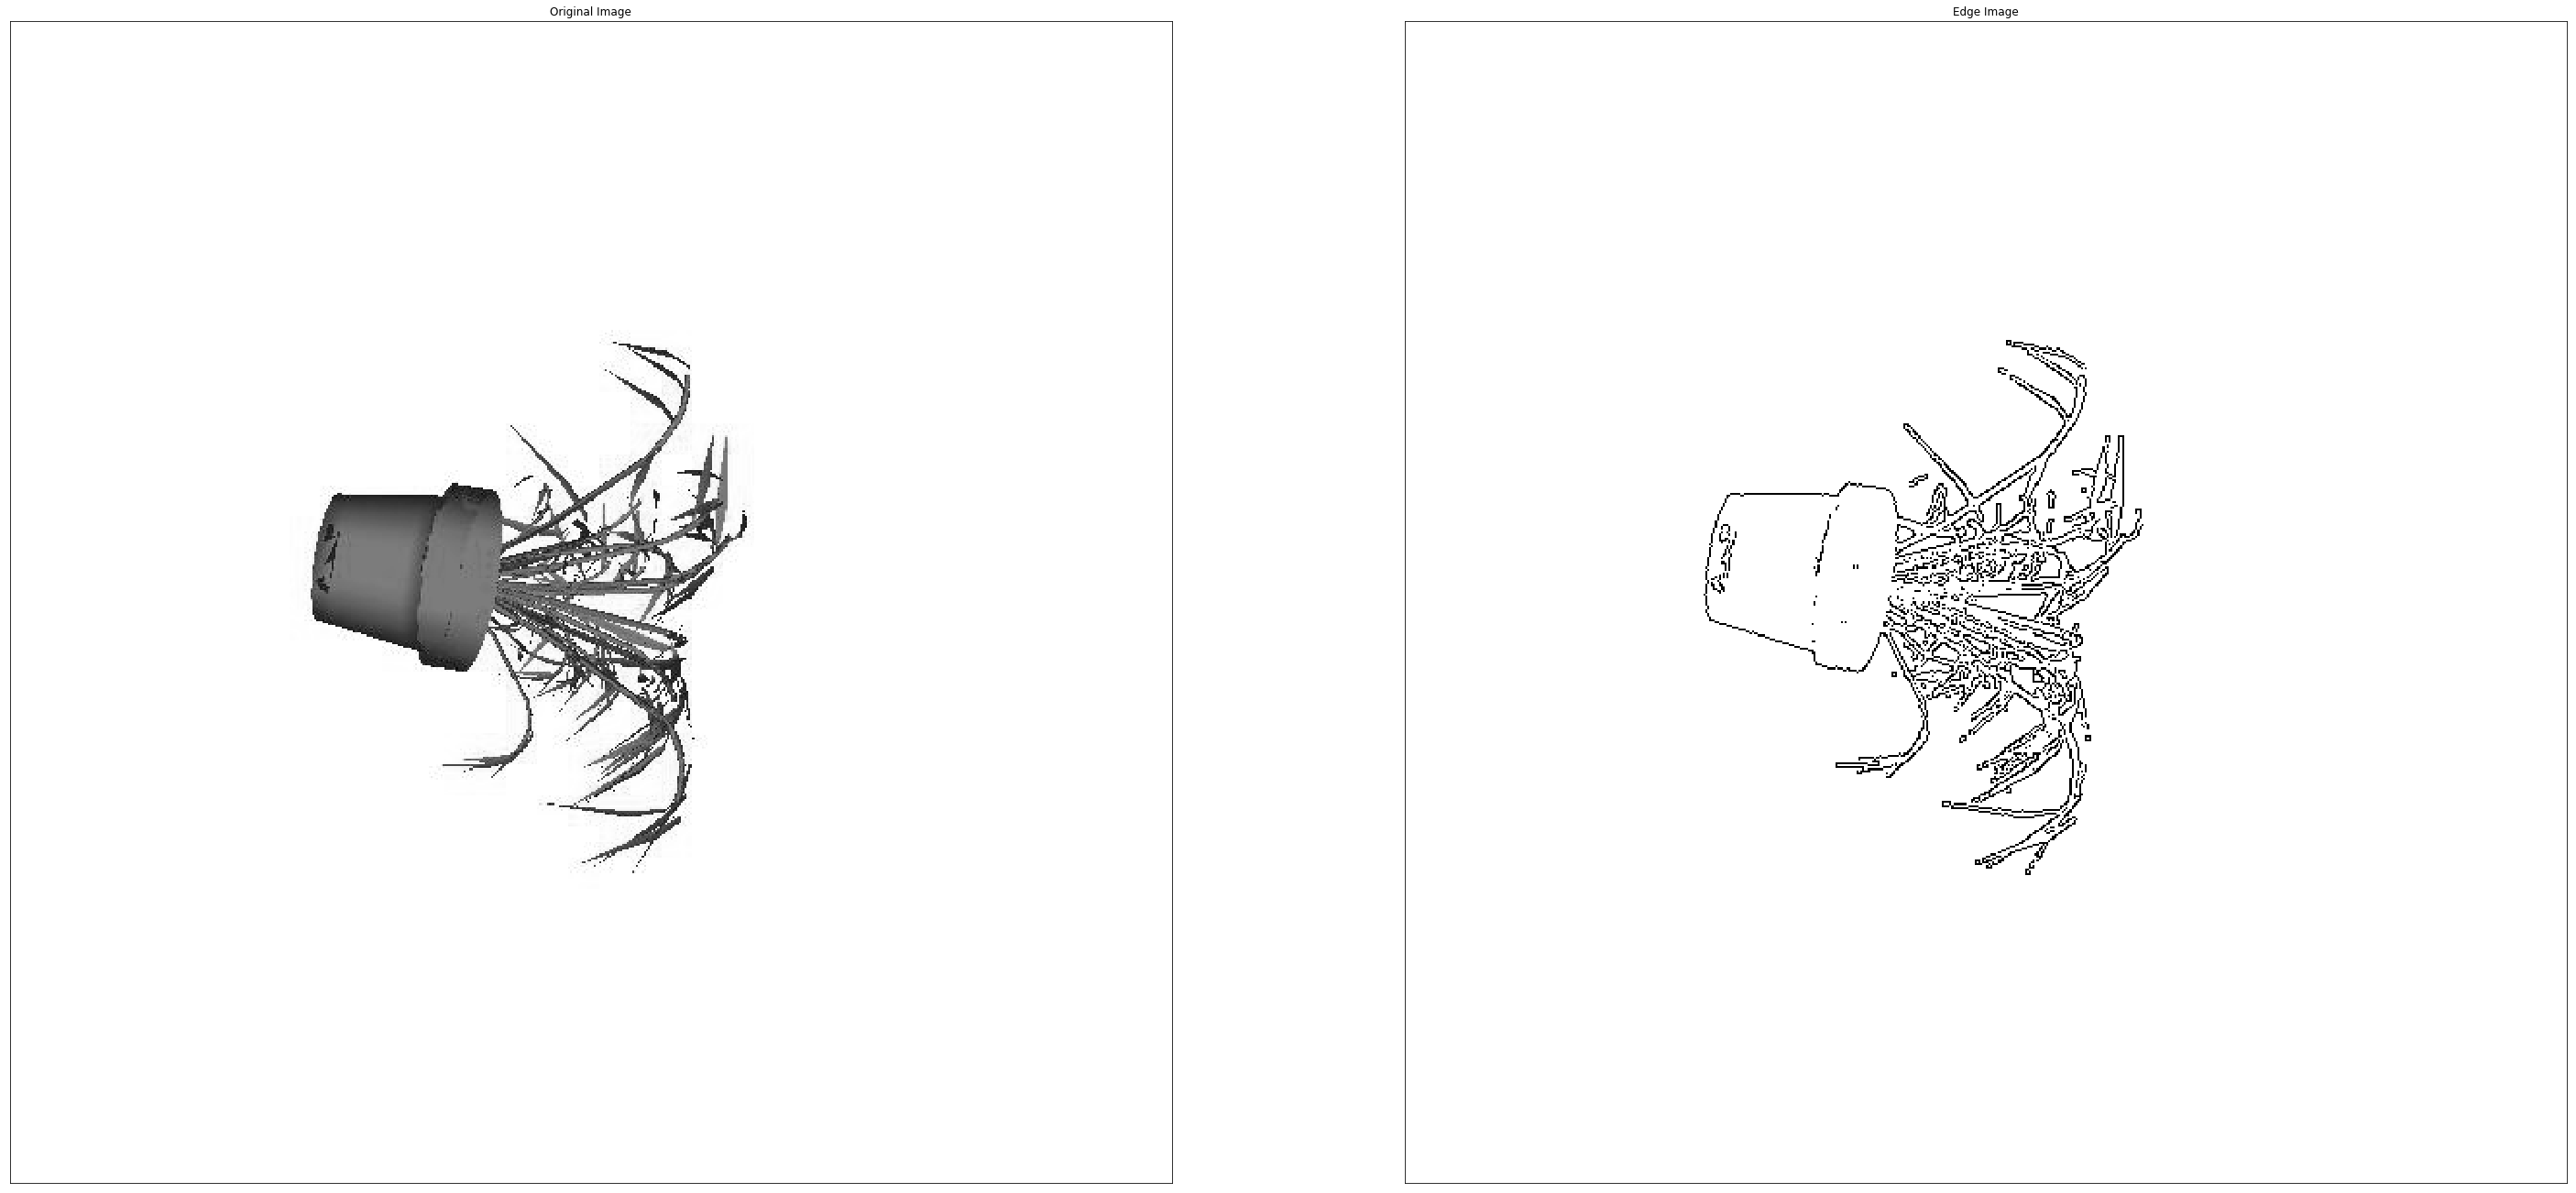

In [88]:
plt.figure(figsize=(50,50))
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(255-edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

255
0
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 

In [91]:
# by default, the sketch size is 600
# gabor filter 
def get_gabor_value(u, v, sigma_x, sigma_y, w0, theta):
    x = u* math.cos(theta)-v*math.sin(theta)
    y = u* math.sin(theta)+v*math.cos(theta)    
    res = math.exp(-2*(math.pi**2)*(((x-w0)**2)*sigma_x**2 + (y**2)*sigma_y**2))
    return res 

def get_gabor_filter(theta, side_length = 600, line_width = 0.02, lamb = 0.2, w = 0.13):
    sigma_x = line_width * w
    sigma_y = sigma_x / lamb 
    u = np.arange(-side_length/2, side_length/2)
    v = np.arange(-side_length/2, side_length/2)
    g = np.zeros([side_length,side_length])
    for i in range (side_length):
        for j in range (side_length):
            x = u[j]
            y = v[i]
            g[i][j] = get_gabor_value(x,y,sigma_x,sigma_y,w,theta)
    return g
    
def get_gabor_bank(imgpath, k = 8):
    thetas = np.linspace(0,math.pi, k+1)[:-1]
    index = 0
    for theta in thetas:
        g = get_gabor_filter(theta)
        index = index + 1 
        plt.savefig("%stheta=%02d.png" % (imgpath, index))

# gabor response 
# frequency method of the article 
def get_gabor_response1(theta, img, w0):
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    g = get_gabor_filter(theta,w = w0)
    response_fft = np.multiply(img_fft,g)
    response = np.fft.ifft2(np.fft.ifftshift(response_fft))
    return np.abs(response)
# internal method of the skimage
def get_gabor_response2(theta,img,w0):
    kernel = gabor_kernel(w0, theta)
    new_img = cv2.filter2D(img,-1,np.real(kernel),borderType= cv2.BORDER_CONSTANT)
    return new_img

# feature extraction 
def get_feature_vector(image,k,n,samples):
    # k the number of orientation
    # image : the original image (gray,single-channel)
    # n: number of tails 
    # samples: s*s number of points to sample
    thetas = np.linspace(0,math.pi, k+1)[:-1]
    responses = []
    for theta in thetas:
        res_image =  get_gabor_response2(theta, image, 0.13)
        res_image = response_mask(res_image, image)
        responses.append(res_image)
    feature = []
    points = get_sampling_points(image.shape[0],image.shape[1],samples)
    for point in points:
        patch_feature = []
        for i in range(k):
            res_image = responses[i]
            res_feature = get_patch_response(res_image,point,n,ratio=0.2)
            patch_feature = patch_feature + res_feature
        if np.sum(patch_feature)!=0.0: 
            norm = np.sqrt(np.sum(np.multiply(patch_feature, patch_feature)))
            patch_feature = patch_feature/norm
            feature.append(patch_feature)
            #print(patch_feature)
    return feature
    
def get_single_direction_feature(image,tail):
    # image : the response image 
    # tail : the number of subdivision along one dimension
    h = image.shape[0]
    w = image.shape[1]
    h_len = int(h/tail)
    w_len = int(w/tail)
    response = []
    for i in range (tail):
        for j in range (tail):
            sub_image = image[i*h_len:(i+1)*h_len,j*w_len:(j+1)*w_len]
            sub_res = np.sum(sub_image)
            response.append(sub_res)
    return response
    
def response_mask(res_img, ori_img):
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    for i in range(ori_img.shape[0]):
        flag = False
        for j in range(ori_img.shape[1]):
            if ori_img[i][j]< 5:
                min_y = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[0]-1,-1,-1):
        flag = False
        for j in range(ori_img.shape[1]):
            if ori_img[i][j]< 5:
                max_y = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[1]):
        flag = False
        for j in range(ori_img.shape[0]):
            if ori_img[j][i]< 5:
                min_x = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[1]-1,-1,-1):
        flag = False
        for j in range(ori_img.shape[0]):
            if ori_img[j][i]< 5:
                max_x = i
                flag = True
                break
        if flag:
            break
    mask = np.zeros(ori_img.shape)
    mask[min_y:max_y,min_x:max_x] = 1
    return np.multiply(mask,res_img)

# sampling 
def get_sampling_points(h,w,n):
    x_sample = random.sample(range(0,w),n)
    y_sample = random.sample(range(0,h),n)
    return [[i,k] for i in x_sample for k in y_sample]

def get_patch_response(image,point,n,ratio=0.2):
    # image : masked image response 
    # n: number of tails 
    w = image.shape[1]
    h = image.shape[0]
    ratio_x = math.sqrt(ratio)
    patch_x = int(w * ratio_x) 
    patch_y = int(h * ratio_x)
    patch = np.zeros([patch_y,patch_x])
    # coordinates in the original image 
    img_x0 = max(0,int(point[0]-patch_x/2))
    img_x1 = min(w-1,int(point[0]+patch_x/2))
    img_y0 = max(0,int(point[1]-patch_y/2))
    img_y1 = min(h-1,int(point[1]+patch_y/2))
    # coordinates in the patch image 
    patch_x0 = int(patch_x/2 -(point[0]-img_x0))
    patch_x1 = int(patch_x/2 +(img_x1-point[0]))
    patch_y0 = int(patch_y/2 -(point[1]-img_y0))
    patch_y1 = int(patch_y/2 +(img_y1-point[1]))
    patch[patch_x0:patch_x1,patch_y0:patch_y1] = image[img_x0:img_x1,img_y0:img_y1]
    return get_single_direction_feature(patch,n)
    
    

In [92]:
a = [0.0,0.0,0.0]
np.sum(a)

0.0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01728364 0.10766268 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01800379
 0.10298169 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.0118825  0.10550222 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01332281 0.23512953 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01620341
 0.61969054 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01548326 0.65209736 0.
 0.         0.         0.         0.    

 0.         0.        ]
[0.50996518 0.         0.         0.         0.00576232 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.37249273 0.
 0.         0.         0.01543478 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.29490723 0.         0.         0.
 0.03231014 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.2899681  0.         0.         0.         0.03086956 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.29058549 0.
 0.         0.         0.01790435 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.2401652  0.         0.         0.
 0.01625797 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.22946375 0.         0.       

In [32]:
math.sqrt(0.2)

0.4472135954999579

In [49]:
point = [6,10]
ratio = 0.2
w = 600
h = 600
ratio_x = math.sqrt(ratio)
patch_x = int(w * ratio_x) 
patch_y = int(h * ratio_x)
print(patch_x)
patch = np.zeros([patch_y,patch_x])
patch[:,:] = 255

# coordinates in the original image 
img_x0 = max(0,int(point[0]-patch_x/2))
img_x1 = min(w-1,int(point[0]+patch_x/2))
img_y0 = max(0,int(point[1]-patch_y/2))
img_y1 = min(h-1,int(point[1]+patch_y/2))
patch_x0 = int(patch_x/2 -(point[0]-img_x0))
patch_x1 = int(patch_x/2 +(img_x1-point[0]))
patch_y0 = int(patch_y/2 -(point[1]-img_y0))
patch_y1 = int(patch_y/2 +(img_y1-point[1]))
patch[patch_x0:patch_x1,patch_y0:patch_y1] = image[img_x0:img_x1,img_y0:img_y1]

# for tailes 
tail = 4



268
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


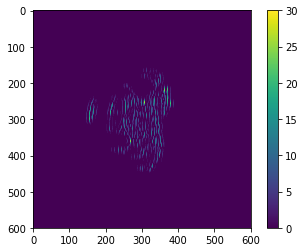

In [63]:
new_img = get_gabor_response2(0,edges,0.13)
plt.imshow(response_mask(new_img, edges))
plt.colorbar()
plt.show()

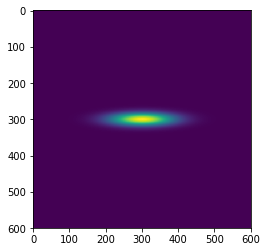

[[6.44948999e-19 2.12199632e-18 1.64248593e-18 ... 4.87563243e-19
  5.90116073e-19 2.61507001e-18]
 [6.26304426e-19 2.12960783e-18 1.62179042e-18 ... 4.74099974e-19
  5.74734249e-19 2.62556003e-18]
 [5.71202685e-19 2.15273541e-18 1.56069220e-18 ... 4.34969882e-19
  5.30126887e-19 2.65689690e-18]
 ...
 [4.82138939e-19 2.19214800e-18 1.46211249e-18 ... 3.73949809e-19
  4.60948130e-19 2.70846422e-18]
 [5.71202727e-19 2.15273552e-18 1.56069227e-18 ... 4.34969942e-19
  5.30126868e-19 2.65689689e-18]
 [6.26304372e-19 2.12960787e-18 1.62179042e-18 ... 4.74100045e-19
  5.74734168e-19 2.62556000e-18]]


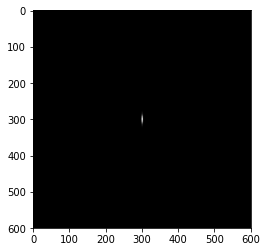

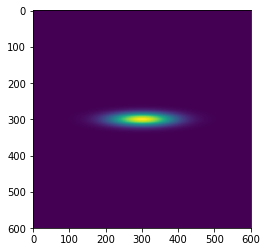

In [11]:
g = get_gabor_filter(0) 
plt.imshow(g, interpolation="nearest")
plt.show()
ifft = np.fft.ifftshift(np.fft.ifft2(g))
ma = np.amax(np.abs(ifft))
mi = np.amin(np.abs(ifft))
ifft = np.abs(ifft)
ifft = (ifft-mi)/ma
print(ifft)
plt.imshow(ifft,cmap='gray',clim=(0,1),interpolation="nearest")
plt.show()

plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(ifft))))  

30.0
0.0
25.0
0.0
24.0
0.0
26.0
0.0
26.0
0.0
29.0
0.0
26.0
0.0
25.0
0.0


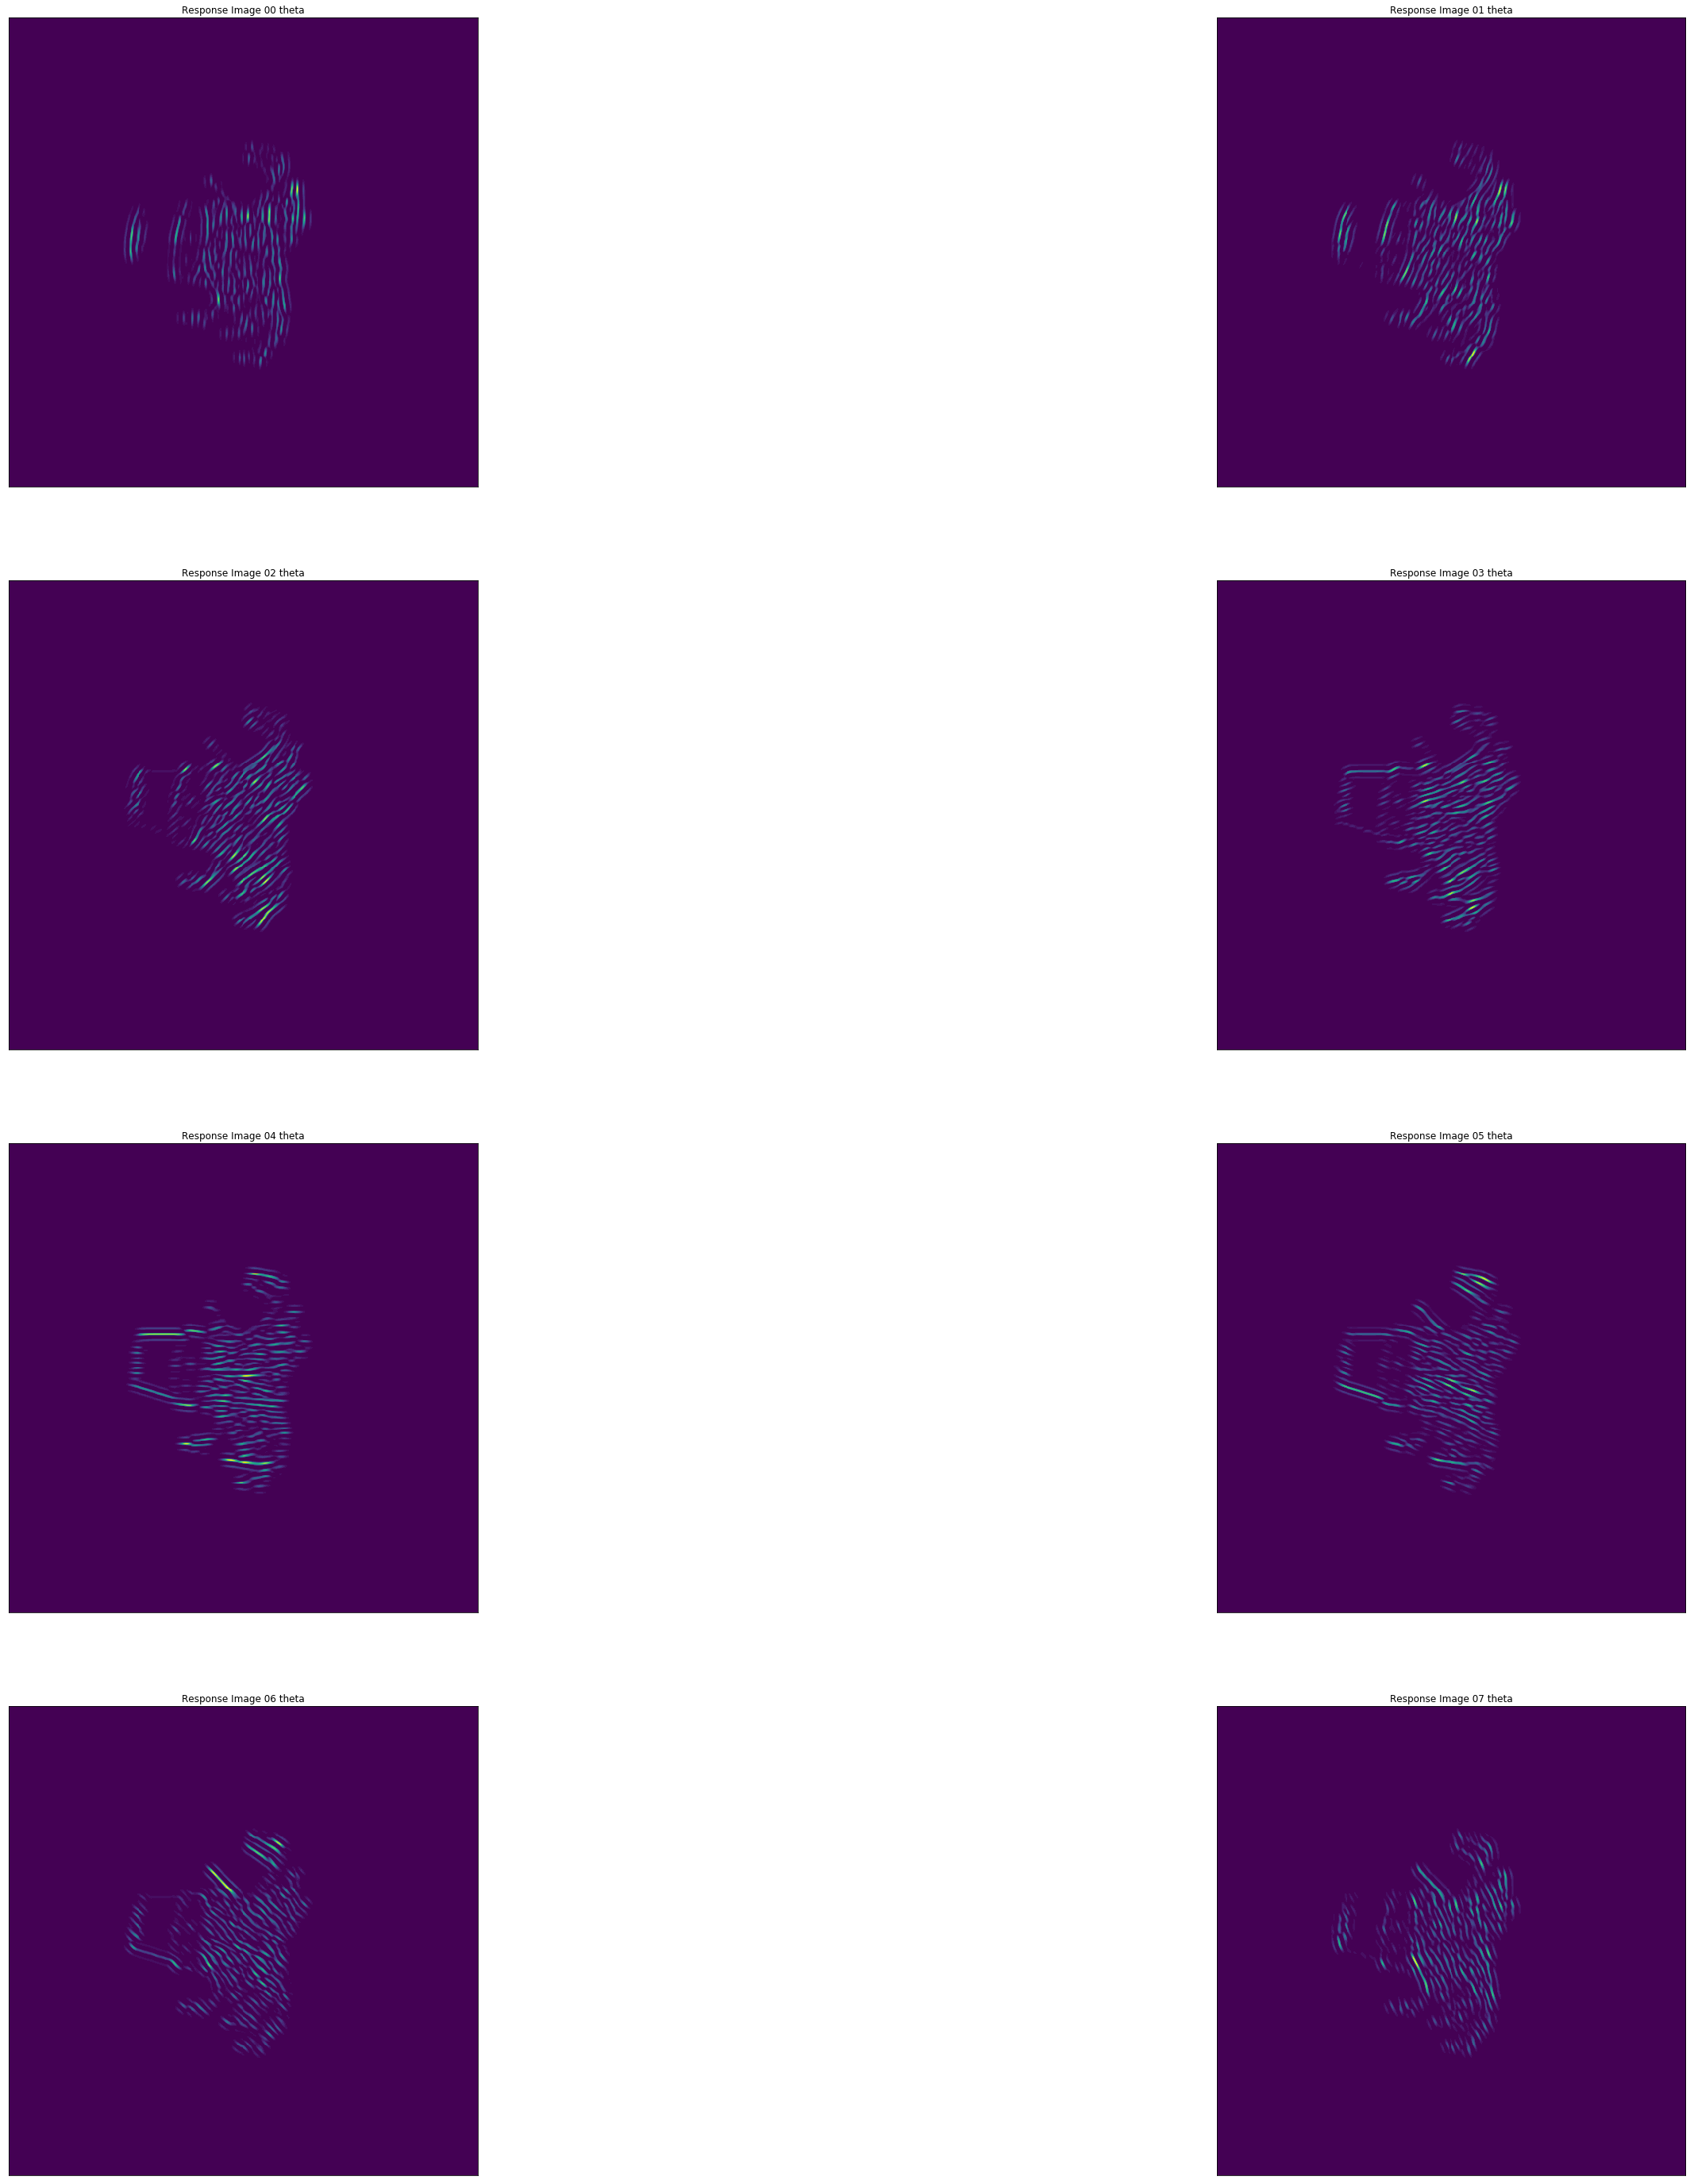

In [23]:
# gabor bank response test 
#image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
thetas = np.linspace(0,math.pi,9)[:-1]
plt.figure(figsize=(50,50))
for i in range (8):
    theta = thetas[i]
    response = get_gabor_response2(theta,edges,0.13)
    response = response_mask(response, edges)
    print(np.amax(response))
    print(np.amin(response))
    plt.subplot(4,2,i+1), plt.imshow(response)
    plt.title('Response Image %02d theta' % i), plt.xticks([]), plt.yticks([])
plt.show()
   


In [13]:
# test feature extraction 
feature_v = get_feature_vector(edges,8,4)
print(feature_v)

[9.59074452e-13 1.20509265e-11 7.40635615e-05 1.05271080e-12
 4.52471529e-07 1.45296253e-01 2.00394161e-01 9.71690397e-10
 1.92838339e-07 1.55464036e-01 1.99476213e-01 1.07399928e-09
 8.24222898e-12 4.87893344e-05 2.39671389e-04 9.47180515e-12
 9.60000060e-13 3.79172353e-07 4.41360945e-05 9.91539053e-13
 1.86478941e-04 1.45229155e-01 2.00387335e-01 1.68896678e-09
 6.72914154e-07 1.55684605e-01 1.99251024e-01 1.52155379e-09
 1.38380450e-12 1.96641152e-06 2.08049081e-04 1.67533881e-12
 4.34647984e-15 2.98727182e-06 2.14303948e-06 4.11662214e-15
 9.12222156e-04 1.44230832e-01 2.00886677e-01 1.18099781e-13
 3.94461572e-05 1.56621851e-01 1.98237015e-01 1.17102070e-13
 3.28510528e-15 1.85198588e-11 6.06293157e-05 3.36339090e-15
 6.59107341e-12 2.58027417e-09 1.67885425e-09 3.17127285e-17
 1.43204684e-03 1.42828335e-01 2.01911738e-01 1.45818535e-16
 2.10521714e-04 1.57949413e-01 1.96660626e-01 1.53325932e-16
 5.68963721e-12 1.66588511e-09 1.14439333e-06 2.93870906e-17
 1.31716315e-12 1.322962

In [84]:
a = []
b = [1,2,3]
a+b

[1, 2, 3]

0.09765625
0.029296875
[[-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]
 [-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]
 [-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]
 ...
 [-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]
 [-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]
 [-17.5 -16.5 -15.5 ...  14.5  15.5  16.5]]
[[-17.5 -17.5 -17.5 ... -17.5 -17.5 -17.5]
 [-16.5 -16.5 -16.5 ... -16.5 -16.5 -16.5]
 [-15.5 -15.5 -15.5 ... -15.5 -15.5 -15.5]
 ...
 [ 14.5  14.5  14.5 ...  14.5  14.5  14.5]
 [ 15.5  15.5  15.5 ...  15.5  15.5  15.5]
 [ 16.5  16.5  16.5 ...  16.5  16.5  16.5]]


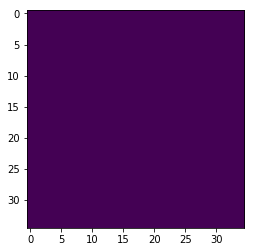

0.09325484946790742
0.027976454840372228


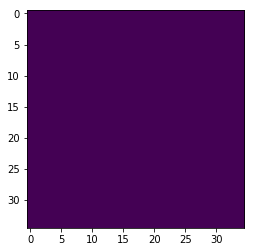

In [9]:
theta = 0
w = 0.13
linewidth = 0.02
width = 512
lamb = 0.3
sigma_x = linewidth * width
sigma_y = sigma_x/ lamb
print(1./sigma_x)
print(1./sigma_y)
l = np.ceil(max(np.abs(sigma_x*math.cos(theta)+sigma_y*math.sin(theta)), np.abs(sigma_x*math.sin(theta)+sigma_y*math.cos(theta))))
x = np.arange(-l/2,l/2)
y = np.arange(-l/2,l/2)
u, v = np.meshgrid(x,y)
U_theta = u*math.cos(theta) + v* math.sin(theta)
V_theta = -u*math.sin(theta) + v* math.cos(theta)
print(U_theta)
print(V_theta)

g = np.exp(-2*(math.pi**2)*(U_theta**2*(sigma_x**2) + (V_theta**2)*(sigma_y**2)))
plt.imshow(g, interpolation="nearest")
plt.show()
print(3./(math.pi*sigma_x))
print(3./(math.pi*sigma_y))

plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(g))))
plt.show()

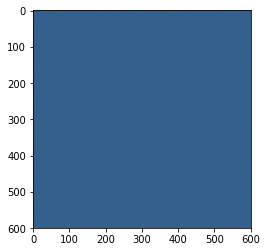

In [10]:
edge_fft = np.fft.fft2(edges)
real = np.real(edge_fft)
plt.imshow(real)
plt.show()

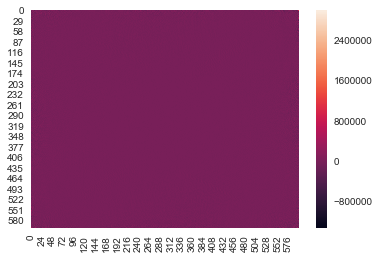

In [11]:
import seaborn as sns
sns.set()
sns.heatmap(real)

In [12]:
np.amin(real)

-1320581.6623087851

In [13]:
np.amax(real)

2993700.0

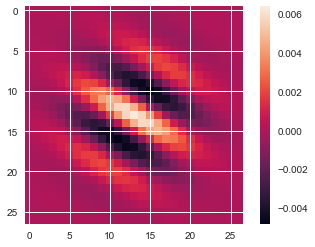

(27, 27)


In [56]:
from skimage.filters import gabor_kernel
kernel = gabor_kernel(0.13,4*math.pi/6,sigma_x = 5, sigma_y = 5)
plt.imshow(np.real(kernel), interpolation='nearest')
plt.colorbar()
plt.show()
print(kernel.shape)

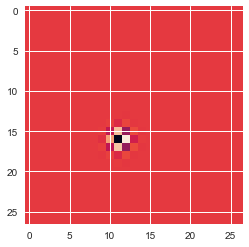

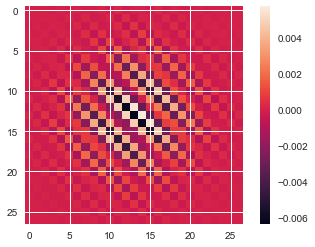

In [57]:
inv_kernel = np.fft.fftshift(np.fft.fft2(kernel))
plt.imshow(np.real(inv_kernel),interpolation='nearest')
plt.show()
plt.imshow(np.real(np.fft.ifft2(inv_kernel)),interpolation='nearest')
plt.colorbar()
plt.show()

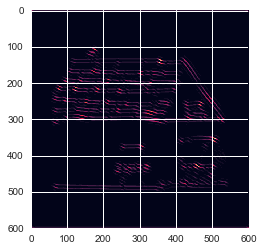

[[9 9 8 ... 0 0 0]
 [7 8 9 ... 3 0 0]
 [3 5 6 ... 6 5 3]
 ...
 [3 5 6 ... 6 5 3]
 [0 0 3 ... 9 8 7]
 [0 0 0 ... 8 9 9]]
22
0


In [58]:

new_img = cv2.filter2D(image,-1,np.real(kernel),borderType= cv2.BORDER_CONSTANT)
plt.imshow(new_img)
plt.show()
print(new_img)
print(np.amax(new_img))
print(np.amin(new_img))

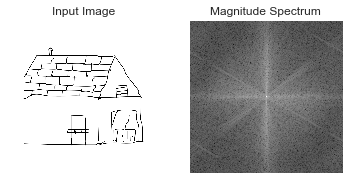

In [16]:
dft = cv2.dft(np.float32(image),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


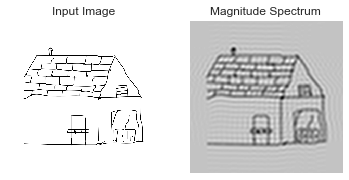

In [17]:
rows, cols = image.shape[0], image.shape[1]
crow, ccol = int(rows/2) , int(cols/2)
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[(crow-30):(crow+30),(ccol-30):(ccol+30)] = 1
# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [19]:
def getGabor_value(u, v, sigma_x, sigma_y, w0, theta = 0):
    x = u* math.cos(theta)-v*math.sin(theta)
    y = u* math.sin(theta)+v*math.cos(theta)    
    res = math.exp(-2*(math.pi**2)*(((x-w0)**2)*sigma_x**2 + (y**2)*sigma_y**2))
    return res

# get the gabor filter in frequency domain
def getGabor_filter(theta, w0 = 0.13, n_stds = 3, img_size = 600,sigma_xy = 0.02, linewidth = 0.3):
    sigma_x = linewidth * w0
    sigma_y = sigma_x/sigma_xy
    x0 = np.ceil(max(np.abs(n_stds * sigma_x * np.cos(theta)),1))
    #y0 = np.ceil(max(np.abs(n_stds * sigma_y * np.cos(theta)),
                     #np.abs(n_stds * sigma_x * np.sin(theta)), 1))
    #y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]
    g = np.zeros([int(2*x0+1),int(2*x0+1)])
    w00 = 2.*w0*np.cos(theta)/(2.*x0+1)
    y = np.arange(-x0,x0+1)*w00
    x = np.arange(-x0,x0+1)*w00
    print(y)
    print(x)
    for i in range(0,len(y)):
        for j in range(0,len(x)):
            u = x[j]
            v = y[i]
            g[i][j] = getGabor_value(u,v,sigma_x,sigma_y,w0,theta)
    return g


[-0.08666667  0.          0.08666667]
[-0.08666667  0.          0.08666667]


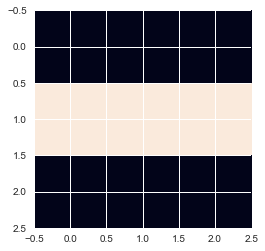

In [20]:
gabor_filter = getGabor_filter(0,0.13)
plt.imshow(gabor_filter)
plt.show()

In [21]:
def getGabor(u, v, w0 = 0.13, theta = 0, sigma_x = 5, sigma_y = 10):
    sigma_y = sigma_x/0.3
    theta = 0.*math.pi/4
    x = u* math.cos(theta)-v*math.sin(theta)
    y = u* math.sin(theta)+v*math.cos(theta)    
    res = math.exp(-2*(math.pi**2)*(((x-w0)**2)*sigma_x**2 + (y**2)*sigma_y**2))
    return res

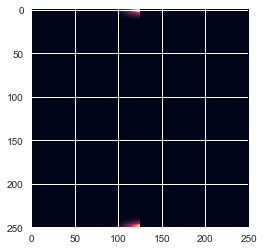

In [22]:
im = np.zeros(edges.shape)
h = im.shape[0]
w = im.shape[1]

im = np.zeros([250,250])
for i in range(-125,125):
    u = float(i*0.001)
    for j in range(-125,125):
        v = float(j*0.001)
        im[j][i] = getGabor(u,v, w0=0.13, sigma_x= 0.02*w)
plt.imshow(im)
plt.show()
#print(im[0])

In [23]:
def getGabor(u, v, w0 = 0.1, sigma_x = 0.5, sigma_y = 10):
    sigma_y = sigma_x/0.3
    theta = 0
    x = u* math.cos(theta)-v*math.sin(theta)
    y = u* math.sin(theta)+v*math.cos(theta)    
    res = math.exp(-2*(math.pi**2)*(((x-w0)**2)*sigma_x**2 + ((y)**2)*sigma_y**2))
    return res

In [24]:
im = np.zeros(edges.shape)
w = len(im)
for i in range(len(im)):
    u = 2*math.pi*i/len(im)
    #print(u)
    for j in range(len(im[0])):
        
        v = 2*math.pi*j/len(im)
        im[i][j] = getGabor(u, v, w0=0.13, sigma_x= 0.02*w)

In [25]:
np.sum(np.multiply(im, im))

2.2470408530142825

/Users/yingyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


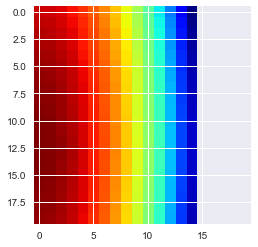

In [26]:
plt.imshow(np.log(im)[0:20,0:20], cmap='jet')
plt.show()

In [27]:
changed = np.abs(np.fft.ifft(np.multiply(np.fft.fft(edges), im)))

TypeError: Image data can not convert to float

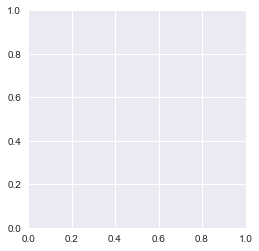

In [28]:
plt.imshow(10**47*changed)
plt.show()

In [ ]:
plt.imshow(np.abs(np.fft.ifft( im)))
plt.show()

In [ ]:
f = np.fft.fft2(np.abs(image))